In [1]:
#import baseic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence


In [3]:
import io
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


**Some helper functions** 

In [6]:
#Function to train a multi-class model. The number of epochs and batch_size are set by the constants at the top of the notebook. 
#Parameters:
        #model : model with the chosen architecture
        #X_train : training features
        #y_train : training target
        #X_valid : validation features
        #Y_valid : validation target
        #Output: model training history
def deep_model(model, X_train, y_train, X_valid, y_valid):  
  model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
  history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
  return history

In [7]:
'''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()


In [8]:
'''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
  model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
  results = model.evaluate(X_test, y_test)
  print()
  print('Test accuracy: {0:.2f}%'.format(results[1]*100))
  return results

In [9]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

In [10]:
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)


In [12]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [13]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [15]:
import nltk
nltk.download('stopwords')
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
#Test-train split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

**Converting words to numbers**

- To use the text as input for a model, we first need to convert the words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the training set.
We clean up the text by applying filters and putting the words to lowercase. Words are separated by spaces.


In [18]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)


After having created the dictionary we can convert the text of a tweet to a vector with NB_WORDS values. With mode=binary, it contains an indicator whether the word appeared in the tweet or not. This is done with the texts_to_matrix method of the Tokenizer.

In [19]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')


**Converting the target classes to numbers**
- We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the to_categorical method in Keras


In [20]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)


**Splitting off a validation set**
- Now that our data is ready, we split off a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model.

In [25]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)


In [26]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.nam = 'Baseline model'

Minimum validation loss reached in epoch 3


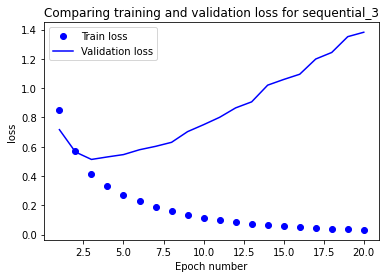

In [27]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

**Handling overfitting...**
- Reduce the network’s capacity by removing layers or reducing the number of elements in the hidden layers


Minimum validation loss reached in epoch 15


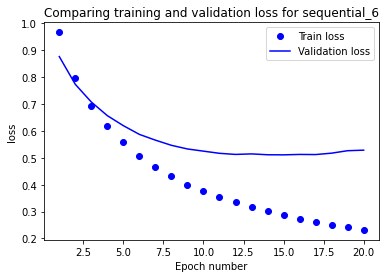

In [30]:
#We reduce the network’s capacity by removing one hidden layer
# and lowering the number of elements in the remaining layer to 16.
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.nam = 'Reduced model'
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

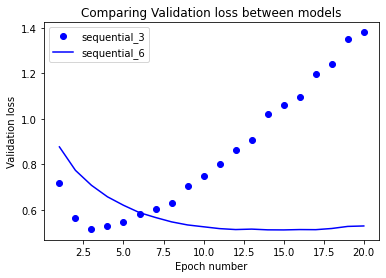

In [31]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

- When we compare the validation loss of the baseline model, it is clear that the reduced model starts overfitting at a later epoch. The validation loss stays lower much longer than the baseline model.

**Applying regularization**
- To address overfitting, we can apply weight regularization to the model. This will add a cost to the loss function of the network for large weights (or parameter values). As a result, you get a simpler model that will be forced to learn only the relevant patterns in the train data.

- There are L1 regularization and L2 regularization.

**L1 regularization** will add a cost with regards to the absolute value of the parameters. It will result in some of the weights to be equal to zero.
**L2 regularization** will add a cost with regards to the squared value of the parameters. This results in smaller weights.
Let’s try with L2 regularization.

In [33]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.nam = 'L2 Regularization model'
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 4


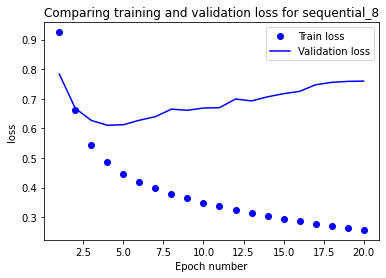

In [34]:
eval_metric(reg_model, reg_history, 'loss')

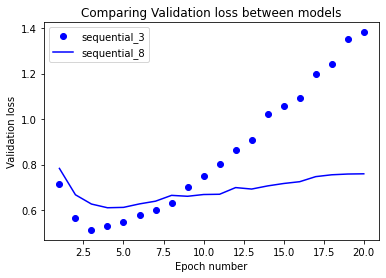

In [35]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

**Adding dropout layers**
- The last option we’ll try is to add Dropout layers. A Dropout layer will randomly set output features of a layer to zero.


Minimum validation loss reached in epoch 7


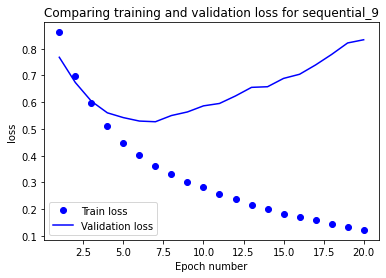

In [36]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.nam = 'Dropout layers model'
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

- The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.

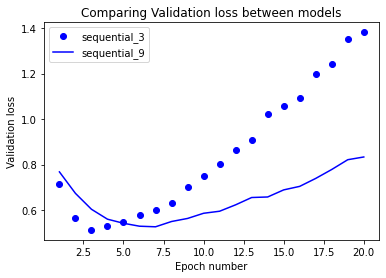

In [37]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')


- The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.

**Training on the full train data and evaluation on test data**

At first sight, the reduced model seems to be the best model for generalization. But let’s check that on the test set.


In [38]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 3ms/step - loss: 1.0624 - accuracy: 0.7650

Test accuracy: 76.50%
46/46 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.7848

Test accuracy: 78.48%
46/46 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.7746

Test accuracy: 77.46%
46/46 [==============================] - 0s 2ms/step - loss: 0.8594 - accuracy: 0.7917

Test accuracy: 79.17%


- As shown above, all three options help to reduce overfitting. We manage to increase the accuracy on the test data substantially. Among these three options, the model with the Dropout layers performs the best on the test data.

This was fun! I will get back to it again.

https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e#:~:text=Overfitting%20occurs%20when%20you%20achieve,are%20irrelevant%20in%20other%20data.&text=The%20best%20option%20is%20to%20get%20more%20training%20data